In [54]:
#Создаем соединение
import psycopg2
import getpass

conn=psycopg2.connect(user='postgres',
                     database='postgres',
                     host='localhost',
                     port='5432',
                     password=getpass.getpass('Insert password'))

Insert password········


In [55]:
# Используем функцию из второго задания, чтобы извлечь матрицу платежей, которая потом пойдет в отчет.

def my_fun2(issuername, cpndate, conn):
    import pandas as pd
    query_bonds="SELECT DISTINCT bond_description.\"ISINCODE\",bond_description.\"ISSUERNAME\", "\
    "bond_description.\"HAVEOFFER\", bond_description.\"COUPONTYPE\", bond_description.\"SECURITYTYPE\","\
    "quotes.\"BUYBACKDATE\", quotes.\"CPN\", quotes.\"CPN_DATE\", quotes.\"CPN_PERIOD\", quotes.\"FACEVALUE\","\
    "quotes.\"MAT_DATE\" FROM bond_description INNER JOIN quotes ON bond_description.\"ISINCODE\"= "\
    "quotes.\"ISIN\" WHERE \"STATUS\"!='Погашен' and \"STATUS\"!='Размещается' and \"HAVEDEFAULT\"='0' AND "\
    "bond_description.\"ISSUERNAME\"="+issuername+" AND quotes.\"CPN_DATE\">="+cpndate+""
    bonds_desc=pd.read_sql_query(query_bonds,conn)
    
    fixed_coup=bonds_desc[['ISINCODE','ISSUERNAME','CPN','CPN_DATE','MAT_DATE','FACEVALUE']][(bonds_desc['COUPONTYPE']=='Постоянный')|(bonds_desc['COUPONTYPE']=='Фиксированный')]
    fixed_coup['CPN'].fillna(0, inplace=True)
    
    import numpy as np
    fixed_coup['CF']=np.where(fixed_coup['CPN_DATE']==fixed_coup['MAT_DATE'], fixed_coup['CPN']+fixed_coup['FACEVALUE'], fixed_coup['CPN'])
    
    fcoup_formatrix=fixed_coup[['ISSUERNAME','ISINCODE','CPN_DATE','CF']]
    
    fcoup_formatrix=fcoup_formatrix.pivot_table(index='ISINCODE', columns='CPN_DATE', values='CF',aggfunc='sum').reset_index().rename_axis(None, axis=1)
    fcoup_formatrix=fcoup_formatrix.fillna(0)

    results={'ISSUERNAME': issuername, 'CPN_DATE': cpndate, 'FMATRIX': fcoup_formatrix }
    return results

In [56]:
# Извлекаем матрицу платежей по облигациям компании "Магнит"
login={'user':'postgres', 'database':'postgres', 'host':'localhost', 'port':'5432'}
issuername='\'Магнит\''
cpndate ='\'2009-06-11\''
x=my_fun2(issuername, cpndate, conn)
x['FMATRIX']

,ISINCODE,2013-08-27,2013-10-01,2014-02-25,2014-04-01,2014-08-26,2014-09-30,2015-02-24,2015-03-31,2015-08-25,2015-09-29,2015-11-13,2016-02-23,2016-03-29
0,RU000A0JTP09,42.38,0.00,42.38,0.00,42.38,0.00,42.38,0.00,42.38,0.00,0.0000,2084.7636,0.0000
1,RU000A0JTT21,0.00,41.88,0.00,41.88,0.00,41.88,0.00,41.88,0.00,41.88,0.0000,0.0000,2083.7649
2,RU000A0JTT39,0.00,41.88,0.00,41.88,0.00,41.88,0.00,41.88,0.00,41.88,0.0000,0.0000,2083.7649
3,RU000A0JVE81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.6643,0.0000,0.0000
4,RU000A0JVE99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.6643,0.0000,0.0000


In [57]:
# Задаем таблицу для построения столбчатой диаграммы
import pandas as pd
query1="SELECT DISTINCT quotes.\"CPN_DATE\", quotes.\"CPN\" FROM bond_description INNER JOIN quotes ON bond_description.\"ISINCODE\"= "\
"quotes.\"ISIN\" WHERE \"STATUS\"!='Погашен' and \"STATUS\"!='Размещается' and \"HAVEDEFAULT\"='0' AND "\
"bond_description.\"ISSUERNAME\"='Магнит' AND bond_description.\"COUPONTYPE\"='Постоянный'"
magnit_cpndate=pd.read_sql_query(query1,conn)
magnit_cpndate.fillna(0)

,CPN_DATE,CPN
0,2013-08-27,42.3800
1,2013-08-27,0.0000
2,2013-10-01,41.8800
3,2013-10-01,0.0000
4,2014-02-25,42.3800
5,2014-04-01,41.8800
6,2014-08-26,42.3800
7,2014-09-30,41.8800
8,2015-02-24,42.3800
9,2015-03-31,41.8800


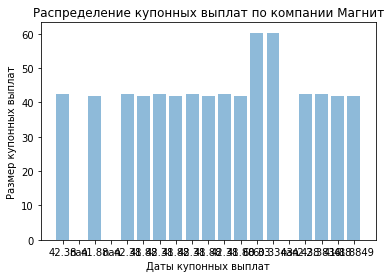

In [59]:
# Строим столбчатую диаграмму, которая пойдте в отчет
import numpy as np
import matplotlib.pyplot as plt

dates=magnit_cpndate['CPN_DATE']
y_pos = np.arange(len(dates))
coupon=magnit_cpndate['CPN']

plt.bar(y_pos, coupon, align='center', alpha=0.5)
plt.xticks(y_pos, coupon)
plt.xlabel("Даты купонных выплат")
plt.ylabel('Размер купонных выплат')
plt.title('Распределение купонных выплат по компании Магнит')

# plt.show()

# Сохраняем в рабочей директории изображение столбчатой диаграммы в формате png

plt.savefig('Распределение купонных выплат по компании Магнит.png')

In [60]:
# Устанавливаем все необходимые надстройки и собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html") 
template_vars = {"title": "Отчет составлен Ширякиной Викторией",
                "INTRO": "Данный отчет содержит информацию по облигациям с фиксированным купоном компании Магнит", 
                 "TABLE_DESC": "В таблице представлена матрица платежей по облигациям с фиксированным купоном компании Магнит", 
                 "TABLE": x['FMATRIX'].to_html(), 
                 "IMAGE_DESC": "На столбчатой диаграмме изображено распределение купонных выплат компании Магнит", 
                 "IMAGE": os.path.realpath('Распределение купонных выплат по компании Магнит.png')
                }
# Собираем и печатаем отчет (Сам отчет выложен в репозитарии)

html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('Magnit_report.pdf', presentational_hints=True)